[![Open in Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/biodatlab/deep-learning-skooldio/blob/master/03_handwritten_recognition_explore.ipynb)

## **Thai-digit handwritten classification with Pytorch: Exploration**

This notebook contains exploration of the "Thai-digit handwritten classification" including
- Customize model
    - Adding layers
    - Adding dropout layer
- Adding data augmentation

## **Download and clean the dataset from the repository**

- We have downloaded the data from https://github.com/kittinan/thai-handwriting-number by cloning the repository
- Remove files that have character mismatch (as suggested by the the creator)
- Then, we put the cleaned data at https://github.com/biodatlab/deep-learning-skooldio

In [2]:
!git clone https://github.com/biodatlab/deep-learning-skooldio

Cloning into 'deep-learning-skooldio'...
remote: Enumerating objects: 1735, done.
remote: Counting objects: 100% (1735/1735), done.
remote: Compressing objects: 100% (1720/1720), done.
remote: Total 1735 (delta 23), reused 1725 (delta 15), pack-reused 0
Receiving objects: 100% (1735/1735), 12.01 MiB | 29.99 MiB/s, done.
Resolving deltas: 100% (23/23), done.


In [3]:
import os
import os.path as op
from glob import glob
from pathlib import Path
import random
from PIL import Image
from collections import Counter

In [4]:
directory = "deep-learning-skooldio/"
paths = glob(op.join(directory, "thai-handwritten-dataset", "*", "*"))
num_samples = len(paths)
print("Number of samples", num_samples)

In [8]:
from tqdm.auto import tqdm
from sklearn.model_selection import train_test_split
import shutil

train_paths, test_paths = train_test_split(paths, test_size=0.1, random_state=42)
for i in range(10):
    os.makedirs(f"data/train/{i}", exist_ok=True)
    os.makedirs(f"data/validation/{i}", exist_ok=True)

In [10]:
def copy_to_destination(src_paths, dst_path: str = "data/train/"):
    for path in tqdm(src_paths):
        path = Path(path)
        if path.parent.name == "10":
            parent_dir = "0"
        else:
            parent_dir = path.parent.name
        shutil.copy(path, op.join(dst_path, parent_dir, path.name))

In [11]:
copy_to_destination(train_paths, "data/train/")
copy_to_destination(test_paths, "data/validation/")

  0%|          | 0/1575 [00:00<?, ?it/s]

  0%|          | 0/175 [00:00<?, ?it/s]

## **Create a custom dataset and a dataloader**

In [12]:
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
import matplotlib.pyplot as plt
import pandas as pd
import os

In [13]:
transform = transforms.Compose([
    transforms.Resize((28, 28)),
    transforms.Grayscale(),
    transforms.ToTensor()
])

In [14]:
# Create dataframe
train_df = pd.DataFrame({"path": glob("data/train/*/*")})
val_df = pd.DataFrame({"path": glob("data/validation/*/*")})

# Create text column from path
train_df["text"] = train_df["path"].apply(lambda x: Path(x).parent.name)
val_df["text"] = val_df["path"].apply(lambda x: Path(x).parent.name)

# Shape of dataframe
print("Number of train images = {}, number of validation images = {},".format(train_df.shape, val_df.shape))

In [19]:
class ThaiDigitDataset(Dataset):
    def __init__(self, dataframe, transform=None):
        self.transform = transform
        self.dataframe = dataframe

    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self, idx):
        label = int(self.dataframe['text'][idx])
        image = Image.open(self.dataframe['path'][idx])
        if self.transform:
            image = 1 - self.transform(image)
        return image, label

In [20]:
train_thaidigit_dataset = ThaiDigitDataset(train_df, transform=transform)
val_thaidigit_dataset = ThaiDigitDataset(val_df, transform=transform)

In [53]:
train_loader = DataLoader(train_thaidigit_dataset, batch_size=16, shuffle=True)
val_loader = DataLoader(val_thaidigit_dataset, batch_size=16, shuffle=False)

## **Create the model**

In [61]:
import torch.nn as nn
import torch.nn.functional as F

class ThaiDigitNet(nn.Module):
    def __init__(self):
        super(ThaiDigitNet, self).__init__()
        self.fc1 = nn.Linear(28 * 28, 100)
        self.fc2 = nn.Linear(100, 10)

    def forward(self, x):
        x = x.view(-1, 28 * 28)
        x = self.fc1(x)
        x = F.relu(x)
        x = self.fc2(x)
        return x

## **Train the model**

In [1]:
# Create training loop function
def train(model, n_epochs, loss_function, optimizer, train_loader, validation_loader):
    training_logs = {"train_loss": [],  "train_acc": [], "val_loss": [], "val_acc": []}
    print("-"*80)
    for epoch in range(1, n_epochs+1):
        # training
        model.train()
        train_loss, correct = 0, 0
        for images, labels in train_loader:
            pred = model(images)
            loss = loss_function(pred, labels)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            train_loss += loss.item()
            correct += (pred.argmax(1) == labels).float().sum().item()
        # save training logs
        training_logs["train_loss"].append(train_loss/ len(train_loader))
        training_logs["train_acc"].append(correct / len(train_loader.dataset))

        # validation
        model.eval()
        val_loss, correct = 0, 0
        for images, labels in validation_loader:
            pred = model(images)
            val_loss += loss_function(pred, labels).item()
            correct += (pred.argmax(1) == labels).float().sum().item()
        # save validation logs
        training_logs["val_loss"].append(val_loss/ len(val_loader))
        training_logs["val_acc"].append(correct / len(validation_loader.dataset))

        print(f"Epochs {epoch}".ljust(10), 
              f"train loss {training_logs['train_loss'][-1]:.5f}",
              f"train acc {training_logs['train_acc'][-1]:.5f}",

              f"val loss {training_logs['val_loss'][-1]:.5f}",
              f"val acc {training_logs['val_acc'][-1]:.5f}",
              )
        print("-"*80)
    return model, training_logs
        

In [67]:
n_epoch = 50

net = ThaiDigitNet() # Initialize the model
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(net.parameters(), lr=0.01)
net, net_history = train(net, n_epoch, loss_fn, optimizer, train_loader, val_loader)

--------------------------------------------------------------------------------
Epochs 1   train loss 2.29240 train acc 0.13841 val loss 2.27477 val acc 0.17714
--------------------------------------------------------------------------------
Epochs 2   train loss 2.25609 train acc 0.22095 val loss 2.23657 val acc 0.20571
--------------------------------------------------------------------------------
Epochs 3   train loss 2.21034 train acc 0.33206 val loss 2.18560 val acc 0.32000
--------------------------------------------------------------------------------
Epochs 4   train loss 2.15199 train acc 0.37270 val loss 2.12028 val acc 0.38286
--------------------------------------------------------------------------------
Epochs 5   train loss 2.07987 train acc 0.42730 val loss 2.04272 val acc 0.43429
--------------------------------------------------------------------------------
Epochs 6   train loss 1.99532 train acc 0.47746 val loss 1.95542 val acc 0.45143
----------------------------

In [ ]:
# Plot the training accuracy and validation accuracy
plt.plot(net_history["train_acc"], label="Train")
plt.plot(net_history["val_acc"], label="Validation")
plt.legend()
plt.title("Train accuracy vs Validation accuracy")
plt.show()

## **Save and load model**



In [68]:
save_path = "thai_digit.pth"
torch.save(net.state_dict(), save_path)  # save model parameters

In [69]:
model_path = "thai_digit.pth"
model = ThaiDigitNet()  # initialize the model
model.load_state_dict(torch.load(model_path))  # load the model weights

<All keys matched successfully>

## **Evaluate the model**

In [70]:
# Create evaluation function for the model
def evaluate(dataframe, model):
    model.eval()
    results = dataframe.copy()
    predictions = []
    for idx, row in results.iterrows():
        img = transform(Image.open(row.path))
        pred = model(1 - img)
        predictions.append(pred.argmax(1).item())

    results["prediction"] = predictions
    
    # Calculate accuracy
    accuracy = len(results[results.prediction == results.text]) / len(results)
    print(f"Accuracy: {accuracy * 100:.2f}%")
    return results

In [71]:
evaluate(val_df, model)

Accuracy: 66.29%


,path,text,prediction
0,data/validation/9/40_a69be344-cfe6-4b09-af57-0...,9,9
1,data/validation/9/445a454e-435a-4e7a-bf57-63ef...,9,9
2,data/validation/9/5f700dba-fecf-4a3f-b49a-2fad...,9,9
3,data/validation/9/1fd3d350-d79b-420e-8052-b2a0...,9,4
4,data/validation/9/f893756e-ed08-47e0-8ed0-4145...,9,9
...,...,...,...
170,data/validation/7/fb7a1f69-8fee-46dc-a14c-91ee...,7,9
171,data/validation/7/376b5857-d33b-4eab-9491-1c34...,7,7
172,data/validation/7/29_5a1c9814-68a2-418c-b73d-a...,7,7
173,data/validation/7/37_a78b761e-2039-4755-b5ec-8...,7,7


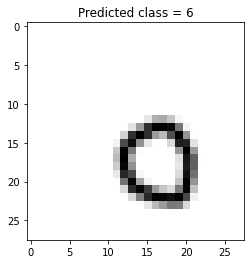

In [73]:
# Show some random images with their predicted number
random_number = random.randint(0, len(val_df))
img = Image.open(val_df.iloc[random_number].path)
img = transform(img)
transformed_img = 1 - img

pred = model(transformed_img).argmax(1)
plt.title(f"Predicted class = {pred.numpy()[0]}")
plt.imshow(img.squeeze(0), cmap="gray")
plt.show()

## **Train neural netowrk model with more layers**

In [74]:
class ThaiDigitMoreLayers(nn.Module):
    def __init__(self):
        super(ThaiDigitMoreLayers, self).__init__()
        self.layers = nn.Sequential(
          
          nn.Linear(28*28, 392),
          nn.ReLU(),
          nn.Linear(392, 196),
          nn.ReLU(),
          nn.Linear(196, 98),
          nn.ReLU(),
          nn.Linear(98, 10),
        )

    def forward(self, x):
        x = x.view(-1, 28 * 28)
        return self.layers(x)
  

In [78]:
n_epochs = 50

more_layers_model = ThaiDigitMoreLayers()
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(more_layers_model.parameters(), lr=0.01)

more_layers_model, more_layers_model_history = train(
    more_layers_model, n_epochs, loss_fn, optimizer, train_loader, val_loader
)


--------------------------------------------------------------------------------
Epochs 1   train loss 2.30362 train acc 0.12571 val loss 2.29841 val acc 0.12000
--------------------------------------------------------------------------------
Epochs 2   train loss 2.30173 train acc 0.12825 val loss 2.29756 val acc 0.14857
--------------------------------------------------------------------------------
Epochs 3   train loss 2.29981 train acc 0.14603 val loss 2.29643 val acc 0.14857
--------------------------------------------------------------------------------
Epochs 4   train loss 2.29796 train acc 0.14984 val loss 2.29513 val acc 0.14857
--------------------------------------------------------------------------------
Epochs 5   train loss 2.29569 train acc 0.16190 val loss 2.29342 val acc 0.15429
--------------------------------------------------------------------------------
Epochs 6   train loss 2.29332 train acc 0.15492 val loss 2.29164 val acc 0.16000
----------------------------

In [80]:
evaluate(val_df, more_layers_model)

Accuracy: 66.29%


,path,text,prediction
0,data/validation/9/40_a69be344-cfe6-4b09-af57-0...,9,9
1,data/validation/9/445a454e-435a-4e7a-bf57-63ef...,9,9
2,data/validation/9/5f700dba-fecf-4a3f-b49a-2fad...,9,9
3,data/validation/9/1fd3d350-d79b-420e-8052-b2a0...,9,4
4,data/validation/9/f893756e-ed08-47e0-8ed0-4145...,9,9
...,...,...,...
170,data/validation/7/fb7a1f69-8fee-46dc-a14c-91ee...,7,9
171,data/validation/7/376b5857-d33b-4eab-9491-1c34...,7,7
172,data/validation/7/29_5a1c9814-68a2-418c-b73d-a...,7,7
173,data/validation/7/37_a78b761e-2039-4755-b5ec-8...,7,7


## **Error analysis**

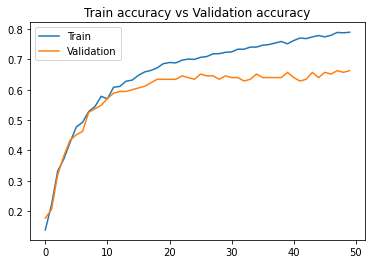

In [100]:
# Plot the training accuracy and validation accuracy
plt.plot(net_history["train_acc"], label="Train")
plt.plot(net_history["val_acc"], label="Validation")
plt.legend()
plt.title("Train accuracy vs Validation accuracy")
plt.show()

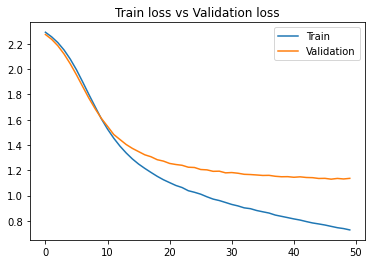

In [102]:
# Plot the training loss and validation loss
plt.plot(net_history["train_loss"], label="Train")
plt.plot(net_history["val_loss"], label="Validation")
plt.legend()
plt.title("Train loss vs Validation loss")
plt.show()

The training accuracy of the model is higher than the validation accuracy.
This means that the model is overfitting the training data.
We can try to reduce the overfitting by adding regularization .

## **Regularization with Dropout**

Dropout is one of the techniques used to prevent overfitting

In [103]:
class DropoutThaiDigit(nn.Module):
    def __init__(self):
        super(DropoutThaiDigit, self).__init__()
        self.fc1 = nn.Linear(28 * 28, 100)
        self.fc2 = nn.Linear(100, 10)
        self.dropout = nn.Dropout(0.25)

    def forward(self, x):
        x = x.view(-1, 28 * 28)
        x = self.fc1(x)
        x = F.relu(x)
        x = self.dropout(x)
        x = self.fc2(x)
        return x

In [105]:
n_epochs = 50
drop_model = DropoutThaiDigit()  # Initialize a model
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(drop_model.parameters(), lr=0.01)

drop_model, drop_model_history = train(drop_model, n_epochs, loss_fn, optimizer, train_loader, val_loader)

--------------------------------------------------------------------------------
Epochs 1   train loss 2.29184 train acc 0.13016 val loss 2.27692 val acc 0.18286
--------------------------------------------------------------------------------
Epochs 2   train loss 2.25714 train acc 0.22921 val loss 2.24391 val acc 0.30286
--------------------------------------------------------------------------------
Epochs 3   train loss 2.21415 train acc 0.29333 val loss 2.20136 val acc 0.33714
--------------------------------------------------------------------------------
Epochs 4   train loss 2.16099 train acc 0.34857 val loss 2.14693 val acc 0.34857
--------------------------------------------------------------------------------
Epochs 5   train loss 2.09564 train acc 0.37714 val loss 2.08029 val acc 0.37714
--------------------------------------------------------------------------------
Epochs 6   train loss 2.02149 train acc 0.41524 val loss 2.00248 val acc 0.41714
----------------------------

In [106]:
evaluate(val_df, drop_model)

Accuracy: 65.71%


,path,text,prediction
0,data/validation/9/40_a69be344-cfe6-4b09-af57-0...,9,9
1,data/validation/9/445a454e-435a-4e7a-bf57-63ef...,9,9
2,data/validation/9/5f700dba-fecf-4a3f-b49a-2fad...,9,9
3,data/validation/9/1fd3d350-d79b-420e-8052-b2a0...,9,4
4,data/validation/9/f893756e-ed08-47e0-8ed0-4145...,9,9
...,...,...,...
170,data/validation/7/fb7a1f69-8fee-46dc-a14c-91ee...,7,9
171,data/validation/7/376b5857-d33b-4eab-9491-1c34...,7,7
172,data/validation/7/29_5a1c9814-68a2-418c-b73d-a...,7,7
173,data/validation/7/37_a78b761e-2039-4755-b5ec-8...,7,7


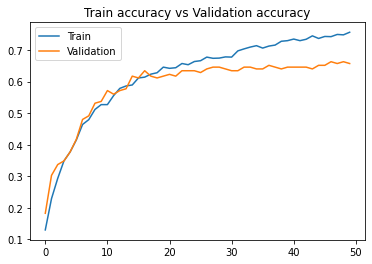

In [107]:
# Plot the training accuracy and validation accuracy
plt.plot(drop_model_history["train_acc"], label="Train")
plt.plot(drop_model_history["val_acc"], label="Validation")
plt.legend()
plt.title("Train accuracy vs Validation accuracy")
plt.show()

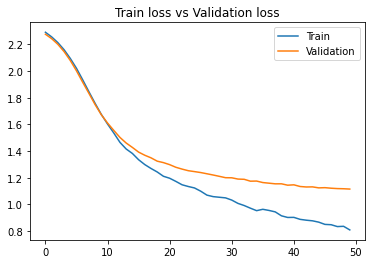

In [108]:
# Plot the training loss and validation loss
plt.plot(drop_model_history["train_loss"], label="Train")
plt.plot(drop_model_history["val_loss"], label="Validation")
plt.legend()
plt.title("Train loss vs Validation loss")
plt.show()

Now the gap between the training accuracy and validation accuracy is smaller than before.

## **Image Augmentation**

Image augmentation is a technique used to artificially increase the size of a training dataset by creating modified versions of existing images.

In [119]:
# augment_transform is same as transform but add RandomAffine to the image

train_transform = transforms.Compose([
    transforms.Resize((28, 28)),
    transforms.Grayscale(),
    transforms.RandomAffine(degrees=(15, 30), translate=(0.05, 0.1), scale=(1, 1)),
    transforms.ToTensor(),
])

val_transform = transforms.Compose([
    transforms.Resize((28, 28)),
    transforms.Grayscale(),
    transforms.ToTensor(),
])

In [120]:
train_thaidigit_dataset = ThaiDigitDataset(train_df, transform=train_transform)
val_thaidigit_dataset = ThaiDigitDataset(val_df, transform=val_transform)

In [121]:
train_dataloader = DataLoader(train_thaidigit_dataset, batch_size=16, shuffle=True)
val_dataloader = DataLoader(val_thaidigit_dataset, batch_size=16, shuffle=False)

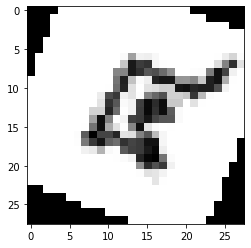

In [122]:
# Example of augmented image
img = (next(iter(train_dataloader))[0][1])
transformed_img = 1 - img

plt.imshow(transformed_img.squeeze(0), cmap="gray")
plt.show()

In [126]:
# Let's train the model with augmented data
n_epochs = 50
augmented_model = DropoutThaiDigit()  # Initialize the model
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(augmented_model.parameters(), lr=0.01)

augmented_model, augmented_model_history = train(
    augmented_model, n_epochs, loss_fn, optimizer, train_dataloader, val_dataloader
)

--------------------------------------------------------------------------------
Epochs 1   train loss 2.28832 train acc 0.12667 val loss 4.52587 val acc 0.19429
--------------------------------------------------------------------------------
Epochs 2   train loss 2.23943 train acc 0.20921 val loss 4.42089 val acc 0.24571
--------------------------------------------------------------------------------
Epochs 3   train loss 2.16621 train acc 0.27143 val loss 4.21919 val acc 0.32000
--------------------------------------------------------------------------------
Epochs 4   train loss 2.06932 train acc 0.32222 val loss 4.00617 val acc 0.38286
--------------------------------------------------------------------------------
Epochs 5   train loss 1.94918 train acc 0.38095 val loss 3.72546 val acc 0.44571
--------------------------------------------------------------------------------
Epochs 6   train loss 1.84236 train acc 0.40190 val loss 3.56098 val acc 0.43714
----------------------------

In [130]:
# Evaluate the new model with old dataset.
evaluate(val_df, augmented_model)

Accuracy: 70.86%


,path,text,prediction
0,data/validation/9/40_a69be344-cfe6-4b09-af57-0...,9,9
1,data/validation/9/445a454e-435a-4e7a-bf57-63ef...,9,9
2,data/validation/9/5f700dba-fecf-4a3f-b49a-2fad...,9,9
3,data/validation/9/1fd3d350-d79b-420e-8052-b2a0...,9,4
4,data/validation/9/f893756e-ed08-47e0-8ed0-4145...,9,9
...,...,...,...
170,data/validation/7/fb7a1f69-8fee-46dc-a14c-91ee...,7,9
171,data/validation/7/376b5857-d33b-4eab-9491-1c34...,7,7
172,data/validation/7/29_5a1c9814-68a2-418c-b73d-a...,7,7
173,data/validation/7/37_a78b761e-2039-4755-b5ec-8...,7,7


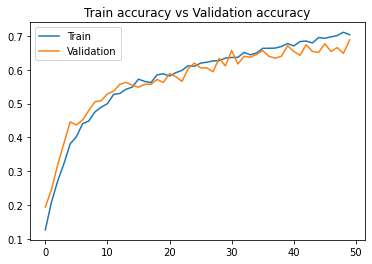

In [132]:
# Plot the training accuracy and validation accuracy
plt.plot(augmented_model_history["train_acc"], label="Train")
plt.plot(augmented_model_history["val_acc"], label="Validation")
plt.legend()
plt.title("Train accuracy vs Validation accuracy")
plt.show()

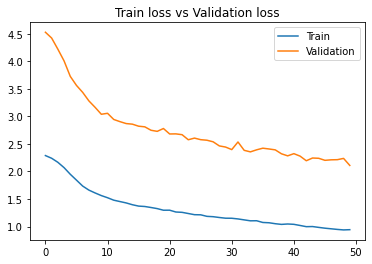

In [131]:
# Plot the training loss and validation loss
plt.plot(augmented_model_history["train_loss"], label="Train")
plt.plot(augmented_model_history["val_loss"], label="Validation")
plt.legend()
plt.title("Train loss vs Validation loss")
plt.show()